In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

In [17]:
class Matching(dict):
    def __init__(self, G: nx.Graph, descriptive: bool = False):
        """Determine a maximam matching from the given bipartite graph `G`.
            G:nx.Graph, the graph from which to determine the matching.
            descriptive:bool, whetever to explain steps or not.
        """
        self._G = G.copy()
        if descriptive:
            self._setup_descriptive()
            self._describe_start()
        for node in G.node:
            if self._is_exposed(node):
                match = self._search(node)
                if match >= 0:
                    self[match] = node
                    if descriptive:
                        self._describe_add(match, node)
                else:
                    self._G.remove_node(node)
                    if descriptive:
                        self._describe_remove(node)

    def _setup_descriptive(self):
        self._pos = nx.kamada_kawai_layout(self._G)

    def _plot(self):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        nx.draw(self._G, pos=self._pos, with_labels=True)
        plt.subplot(1, 2, 2)
        G = nx.Graph()
        print(self)
        colors = []
        for a, b in self.items():
            G.add_node(a)
            G.add_node(b)
            G.add_edge(a, b)
            colors += ['y', 'g']
        nx.draw(G, pos=self._pos, with_labels=True, node_color=colors)
        plt.show()

    def _describe_start(self):
        print("Starting with empty matching.")
        self._plot()

    def _describe_add(self, match: int, node: int):
        print("Adding match {match}:{node}".format(match=match, node=node))
        self._plot()

    def _describe_remove(self, node: int):
        print("Removing {node}".format(node=node))
        self._plot()

    def _is_exposed(self, node: int) -> bool:
        """Return a boolean representing if the given `node` is exposed.
            node:int, the node to check for.
        """
        return not self._is_in_matching(node)

    def _is_in_matching(self, node: int) -> bool:
        """Return a boolean representing if the given node is in the matching.
            node:int, the node to check for.
        """
        return node in self or node in self.values()

    def _get_match(self, node: int) -> int:
        """Return the match for a given node.
            node:int, the node to retrieve a matching for.
        """
        if node in self:
            return self[node]
        for k, v in self.items():
            if v == node:
                return k
        raise ValueError("Given node {node} has no match.".format(node=node))

    def _is_even(self, node: int) -> bool:
        """Return a boolean representing if the given node is labeled as `EVEN`.
            node:int, the node to check parity for.
        """
        return self._labels[node]

    def _is_odd(self, node: int) -> bool:
        """Return a boolean representing if the given node is labeled as `ODD`.
            node:int, the node to check parity for.
        """
        return not self._is_even(node)

    def _is_unlabeled(self, node: int) -> bool:
        """Return a boolean representing if the given node isn't labeled.
            node:int, the node to check labeling for.
        """
        return node not in self._labels

    def _set_node_parity(self, node: int, parity: bool):
        """Set a given node with a given parity label.
            node:int, the node to set to a given parity.
            parity:bool, the value of parity to set it to.
        """
        self._labels[node] = parity

    def _set_even(self, node: int):
        """Set a given node to `EVEN`.
            node:int, the node to set to `EVEN`
        """
        self._set_node_parity(node, True)

    def _set_odd(self, node: int):
        """Set a given node to `ODD`.
            node:int, the node to set to `ODD`
        """
        self._set_node_parity(node, False)

    def _prepend_node(self, node: int):
        """Prepend given `node` to `nodes` list.
            node:int, the node to add to list.
        """
        self._nodes.insert(0, node)

    def _pop_node(self) -> int:
        """Return first node in nodes list."""
        return self._nodes.pop()

    def _reset(self):
        """Reset `labels` dictionary and `nodes` list to a clean state."""
        self._labels, self._nodes = {}, []

    def _search(self, current: int) -> int:
        """Return, if found, the starting node of an augmenting path ending in given `current` node. Otherwise `-1`.
            current:int, the node from which the search will start.
        """
        self._reset()
        self._set_even(current)
        self._prepend_node(current)
        while self._nodes:
            node = self._pop_node()
            if self._is_even(node):
                match = self._search_even(node)
            else:
                self._search_odd(node)
            if match >= 0:
                return match
        return -1

    def _search_even(self, vertex: int):
        """Return, if found, the end of the augmenting path otherwise determines the even odd in the path.
            vertex:int, the even node in the current augmenting path.
        """
        for node in self._G.neighbors(vertex):
            if self._is_exposed(node):
                return node
            if self._is_in_matching(node) and self._is_unlabeled(node):
                self._set_odd(node)
                self._prepend_node(node)
        return -1

    def _search_odd(self, vertex: int):
        """Determine the odd step in the augmenting path.
            vertex:int, the odd node in the current augmenting path.
        """
        node = self._get_match(vertex)
        if self._is_unlabeled(node):
            self._set_even(node)
            self._prepend_node(node)

Starting with empty matching.
{}


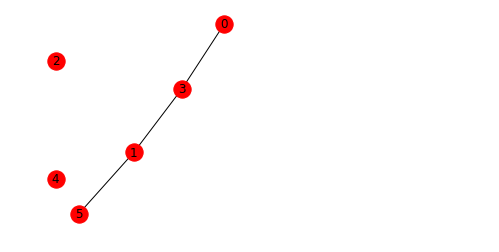

Adding match 3:0
{3: 0}


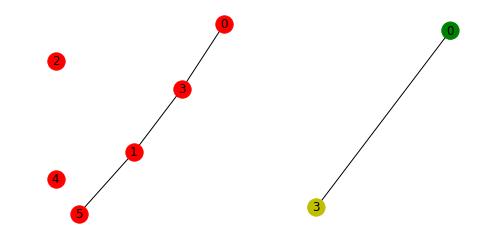

Adding match 5:1
{3: 0, 5: 1}


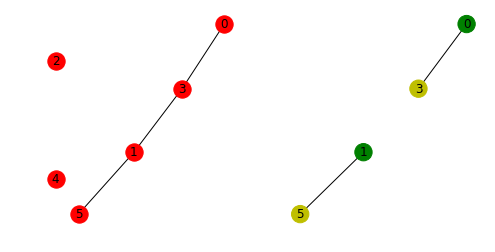

Removing 2
{3: 0, 5: 1}


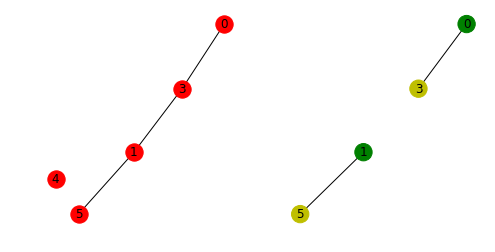

Removing 4
{3: 0, 5: 1}


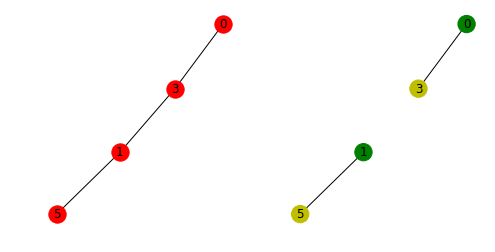

In [18]:
G = bipartite.random_graph(3, 3, 0.5)
M = Matching(G, descriptive=True)